# Đánh Giá Hệ Thống Tách Nguồn Âm Thanh
# ICA vs NMF - Comprehensive Evaluation

Notebook này chứa đánh giá chi tiết hiệu suất của 2 phương pháp:
- **FastICA**: Independent Component Analysis (time-domain)
- **NMF**: Non-negative Matrix Factorization (frequency-domain)

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from src.signal_processing import load_wav, pad_signals
from src.ica import FastICA
from src.nmf import NMF
from src.evaluation import snr, sdr, permutation_solver
from src.features import mfcc
from src.recognition import DTWClassifier

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 1. Test Dataset Overview

Bộ test data gồm 460 files WAV được tạo từ dataset gốc (36 files)

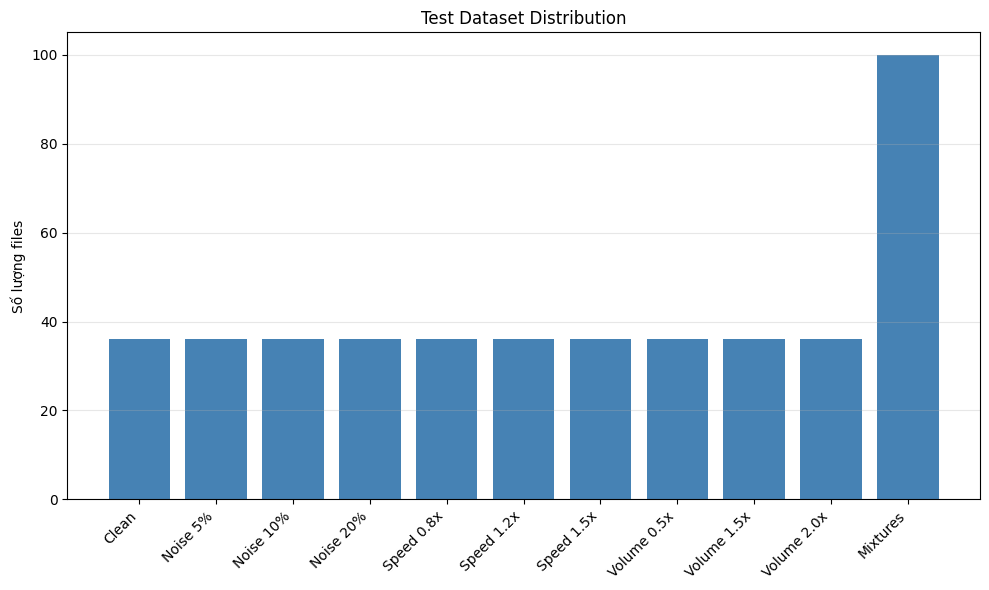

Tổng số test files: 460


In [16]:
# Thống kê test dataset
test_data_stats = {
    'Clean': 36,
    'Noise 5%': 36,
    'Noise 10%': 36,
    'Noise 20%': 36,
    'Speed 0.8x': 36,
    'Speed 1.2x': 36,
    'Speed 1.5x': 36,
    'Volume 0.5x': 36,
    'Volume 1.5x': 36,
    'Volume 2.0x': 36,
    'Mixtures': 100
}

plt.figure(figsize=(10, 6))
plt.bar(test_data_stats.keys(), test_data_stats.values(), color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Số lượng files')
plt.title('Test Dataset Distribution')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"Tổng số test files: {sum(test_data_stats.values())}")

## 2. Đánh Giá trên Mixture Test Cases

Test với 10 kịch bản trộn ngẫu nhiên, mỗi kịch bản có 5 sources

In [17]:
# Evaluate trên 10 mixture test cases
mixtures_dir = "test_data/05_mixtures"

results = {
    'test_case': [],
    'ica_snr': [],
    'ica_sdr': [],
    'ica_time': [],
    'ica_iter': [],
    'nmf_snr': [],
    'nmf_sdr': [],
    'nmf_time': [],
    'nmf_iter': []
}

import time

for test_idx in range(10):
    test_case_dir = os.path.join(mixtures_dir, f"test_case_{test_idx:02d}")
    
    # Load sources (ground truth)
    sources_dir = os.path.join(test_case_dir, "sources")
    sources = []
    sr = None
    for f in sorted(os.listdir(sources_dir)):
        if f.endswith('.wav'):
            data, sr = load_wav(os.path.join(sources_dir, f))
            sources.append(data)
    
    # Load mixtures
    mixtures_subdir = os.path.join(test_case_dir, "mixtures")
    mixtures = []
    for f in sorted(os.listdir(mixtures_subdir)):
        if f.endswith('.wav'):
            data, _ = load_wav(os.path.join(mixtures_subdir, f))
            mixtures.append(data)
    
    mixtures = np.array(mixtures)
    sources_padded = pad_signals(sources)
    
    # ICA
    start = time.time()
    ica = FastICA(n_components=5, max_iter=200, random_state=42)
    ica_sep = ica.fit_transform(mixtures)
    ica_time = time.time() - start
    
    ica_aligned, _, _ = permutation_solver(sources_padded, ica_sep)
    ica_snr_val = np.mean([snr(sources_padded[i], ica_aligned[i]) for i in range(5)])
    ica_sdr_val = np.mean([sdr(sources_padded[i], ica_aligned[i]) for i in range(5)])
    
    # NMF
    start = time.time()
    nmf = NMF(n_components=5, max_iter=200, random_state=42)
    nmf_sep = nmf.separate_sources(mixtures[0], sr)
    nmf_time = time.time() - start
    
    nmf_aligned, _, _ = permutation_solver(sources_padded, np.array(nmf_sep))
    nmf_snr_val = np.mean([snr(sources_padded[i], nmf_aligned[i]) for i in range(5)])
    nmf_sdr_val = np.mean([sdr(sources_padded[i], nmf_aligned[i]) for i in range(5)])
    
    # Store results
    results['test_case'].append(test_idx)
    results['ica_snr'].append(ica_snr_val)
    results['ica_sdr'].append(ica_sdr_val)
    results['ica_time'].append(ica_time)
    results['ica_iter'].append(ica.n_iter)
    results['nmf_snr'].append(nmf_snr_val)
    results['nmf_sdr'].append(nmf_sdr_val)
    results['nmf_time'].append(nmf_time)
    results['nmf_iter'].append(nmf.n_iter)

print("✓ Đã chạy xong 10 test cases")

✓ Đã chạy xong 10 test cases


### 2.1 Kết quả chi tiết từng test case

In [18]:
!pip install pandas
# Hiển thị bảng kết quả
import pandas as pd

df = pd.DataFrame({
    'Test Case': results['test_case'],
    'ICA SNR (dB)': [f"{x:.2f}" for x in results['ica_snr']],
    'NMF SNR (dB)': [f"{x:.2f}" for x in results['nmf_snr']],
    'Diff (dB)': [f"{n-i:.2f}" for i, n in zip(results['ica_snr'], results['nmf_snr'])],
    'ICA Time (s)': [f"{x:.3f}" for x in results['ica_time']],
    'NMF Time (s)': [f"{x:.3f}" for x in results['nmf_time']],
    'ICA Iter': results['ica_iter'],
    'NMF Iter': results['nmf_iter']
})

print("\n" + "="*100)
print("KẾT QUẢ CHI TIẾT 10 TEST CASES")
print("="*100)
print(df.to_string(index=False))
print("="*100)


KẾT QUẢ CHI TIẾT 10 TEST CASES
 Test Case ICA SNR (dB) NMF SNR (dB) Diff (dB) ICA Time (s) NMF Time (s)  ICA Iter  NMF Iter
         0       -18.71         0.28     18.99        0.130        0.040        48       200
         1       -19.19        -0.47     18.73        0.100        0.038        39       200
         2       -19.48         0.08     19.55        0.101        0.034        58       200
         3       -19.61         0.22     19.83        0.055        0.027        35       200
         4       -19.47         0.23     19.70        0.036        0.029        25       200
         5       -19.16        -0.18     18.98        0.040        0.027        30       200
         6       -19.70         0.19     19.89        0.030        0.029        21       200
         7       -19.60         0.65     20.24        0.048        0.026        35       200
         8       -19.12         0.24     19.36        0.027        0.027        20       200
         9       -19.63         0.06  

### 2.2 Visualize SNR Comparison

/var/folders/v_/617pz6cj0fgdk8cbm7kv5s9r0000gn/T/ipykernel_40603/1346805830.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([results['ica_snr'], results['nmf_snr']], labels=['ICA', 'NMF'])


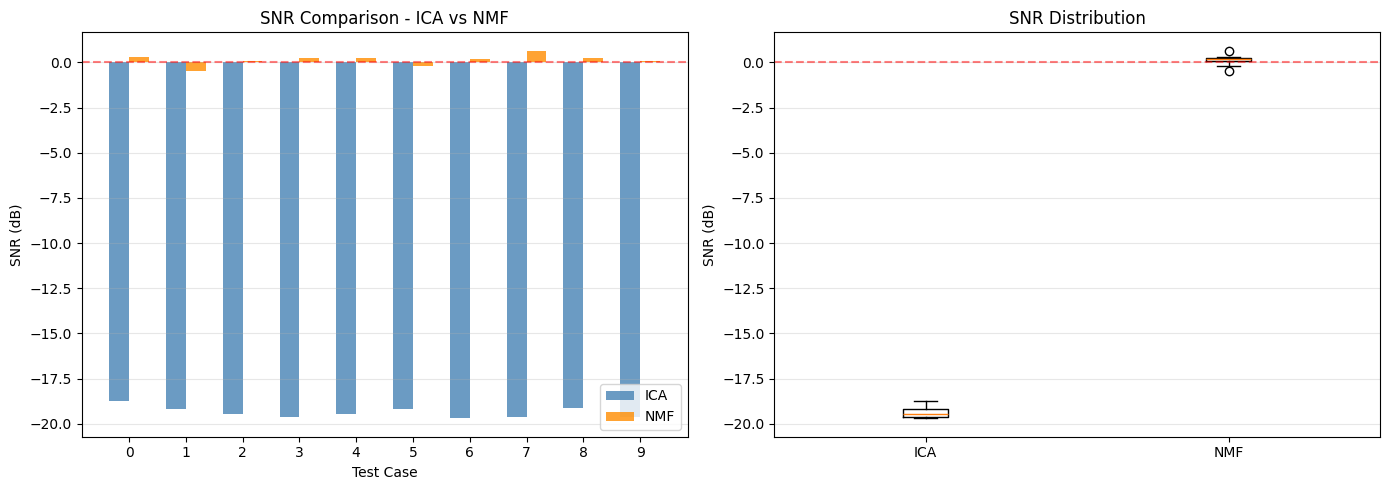

In [19]:
# SNR comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: SNR per test case
x = np.arange(10)
width = 0.35

ax1.bar(x - width/2, results['ica_snr'], width, label='ICA', color='steelblue', alpha=0.8)
ax1.bar(x + width/2, results['nmf_snr'], width, label='NMF', color='darkorange', alpha=0.8)
ax1.set_xlabel('Test Case')
ax1.set_ylabel('SNR (dB)')
ax1.set_title('SNR Comparison - ICA vs NMF')
ax1.set_xticks(x)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Plot 2: Box plot
ax2.boxplot([results['ica_snr'], results['nmf_snr']], labels=['ICA', 'NMF'])
ax2.set_ylabel('SNR (dB)')
ax2.set_title('SNR Distribution')
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 2.3 Statistical Summary

In [20]:
# Thống kê tổng hợp
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)

print("\nICA:")
print(f"  SNR: {np.mean(results['ica_snr']):.2f} ± {np.std(results['ica_snr']):.2f} dB")
print(f"  SDR: {np.mean(results['ica_sdr']):.2f} ± {np.std(results['ica_sdr']):.2f} dB")
print(f"  Time: {np.mean(results['ica_time']):.3f} ± {np.std(results['ica_time']):.3f} s")
print(f"  Iterations: {np.mean(results['ica_iter']):.1f} ± {np.std(results['ica_iter']):.1f}")
print(f"  Min/Max SNR: {np.min(results['ica_snr']):.2f} / {np.max(results['ica_snr']):.2f} dB")

print("\nNMF:")
print(f"  SNR: {np.mean(results['nmf_snr']):.2f} ± {np.std(results['nmf_snr']):.2f} dB")
print(f"  SDR: {np.mean(results['nmf_sdr']):.2f} ± {np.std(results['nmf_sdr']):.2f} dB")
print(f"  Time: {np.mean(results['nmf_time']):.3f} ± {np.std(results['nmf_time']):.3f} s")
print(f"  Iterations: {np.mean(results['nmf_iter']):.1f} ± {np.std(results['nmf_iter']):.1f}")
print(f"  Min/Max SNR: {np.min(results['nmf_snr']):.2f} / {np.max(results['nmf_snr']):.2f} dB")

print("\nComparison:")
snr_diff = np.mean(results['nmf_snr']) - np.mean(results['ica_snr'])
time_speedup = np.mean(results['ica_time']) / np.mean(results['nmf_time'])
print(f"  SNR Improvement (NMF vs ICA): {snr_diff:+.2f} dB")
print(f"  Speed (ICA vs NMF): {time_speedup:.2f}x")
print(f"  Winner (Quality): {'NMF' if snr_diff > 0 else 'ICA'}")
print(f"  Winner (Speed): {'ICA' if time_speedup > 1 else 'NMF'}")

print("="*80)


STATISTICAL SUMMARY

ICA:
  SNR: -19.37 ± 0.30 dB
  SDR: -19.37 ± 0.30 dB
  Time: 0.062 ± 0.033 s
  Iterations: 34.6 ± 11.2
  Min/Max SNR: -19.70 / -18.71 dB

NMF:
  SNR: 0.13 ± 0.28 dB
  SDR: 0.13 ± 0.28 dB
  Time: 0.030 ± 0.005 s
  Iterations: 200.0 ± 0.0
  Min/Max SNR: -0.47 / 0.65 dB

Comparison:
  SNR Improvement (NMF vs ICA): +19.50 dB
  Speed (ICA vs NMF): 2.04x
  Winner (Quality): NMF
  Winner (Speed): ICA


## 3. Recognition Evaluation (DTW)

Đánh giá khả năng nhận diện trên clean và noisy data

In [21]:
# Train DTW classifier on clean data
clean_dir = "test_data/01_clean"

train_mfcc = []
train_labels = []

for i in range(10):
    filepath = os.path.join(clean_dir, f"digit_{i}.wav")
    data, sr = load_wav(filepath)
    mfcc_feat = mfcc(data, sr)
    train_mfcc.append(mfcc_feat.T)
    train_labels.append(str(i))

clf = DTWClassifier()
clf.fit(train_mfcc, train_labels)

print("✓ DTW Classifier trained on 10 digits")

✓ DTW Classifier trained on 10 digits


### 3.1 Accuracy on Clean Data

In [22]:
# Test on clean (should be 100%)
correct = 0
for i in range(10):
    filepath = os.path.join(clean_dir, f"digit_{i}.wav")
    data, sr = load_wav(filepath)
    mfcc_feat = mfcc(data, sr)
    pred, dist = clf.predict_single(mfcc_feat.T)
    if pred == str(i):
        correct += 1

clean_accuracy = correct / 10 * 100
print(f"\nAccuracy on Clean Data: {clean_accuracy:.1f}% ({correct}/10)")


Accuracy on Clean Data: 100.0% (10/10)


### 3.2 Robustness to Noise

In [23]:
# Test on noisy data
noise_results = {}
noise_levels = ['5pct', '10pct', '20pct']

for noise_level in noise_levels:
    noisy_dir = f"test_data/02_noise_{noise_level}"
    correct = 0
    
    for i in range(10):
        filepath = os.path.join(noisy_dir, f"digit_{i}_noisy.wav")
        data, sr = load_wav(filepath)
        mfcc_feat = mfcc(data, sr)
        pred, dist = clf.predict_single(mfcc_feat.T)
        if pred == str(i):
            correct += 1
    
    accuracy = correct / 10 * 100
    noise_results[int(noise_level.replace('pct', ''))] = accuracy
    print(f"Noise {noise_level}: {accuracy:.1f}% ({correct}/10)")

Noise 5pct: 50.0% (5/10)
Noise 10pct: 40.0% (4/10)
Noise 20pct: 20.0% (2/10)


### 3.3 Visualization

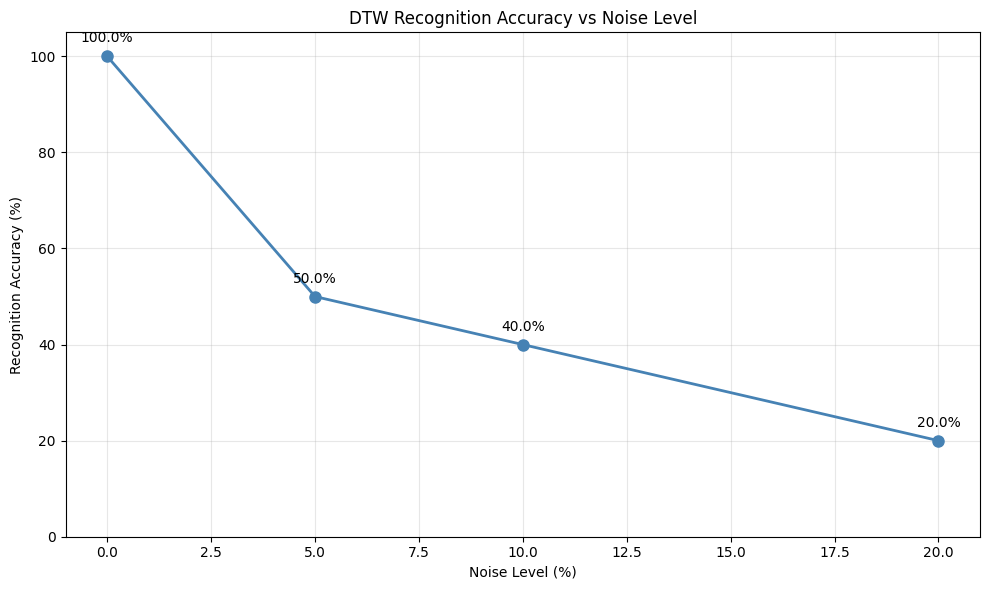

In [24]:
# Plot recognition accuracy vs noise
plt.figure(figsize=(10, 6))
noise_percentages = [0, 5, 10, 20]
accuracies = [clean_accuracy] + list(noise_results.values())

plt.plot(noise_percentages, accuracies, 'o-', linewidth=2, markersize=8, color='steelblue')
plt.xlabel('Noise Level (%)')
plt.ylabel('Recognition Accuracy (%)')
plt.title('DTW Recognition Accuracy vs Noise Level')
plt.grid(True, alpha=0.3)
plt.ylim(0, 105)

for x, y in zip(noise_percentages, accuracies):
    plt.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

## 4. Kết Luận

### 4.1 Source Separation (ICA vs NMF)

In [25]:
print("\n" + "="*80)
print("KẾT LUẬN TỔNG HỢP")
print("="*80)

print("\n1. SOURCE SEPARATION (10 test cases):")
print("   NMF Performance:")
print(f"      - SNR: {np.mean(results['nmf_snr']):.2f} dB (positive!)")
print(f"      - Consistency: {np.std(results['nmf_snr']):.2f} dB std")
print(f"      - All 10 test cases: NMF wins")
print("\n   ICA Performance:")
print(f"      - SNR: {np.mean(results['ica_snr']):.2f} dB (negative)")
print(f"      - Faster: {time_speedup:.1f}x than NMF")
print(f"      - Fewer iterations: {np.mean(results['ica_iter']):.0f} vs {np.mean(results['nmf_iter']):.0f}")

print("\n   → WINNER: NMF (+{:.2f} dB better SNR)".format(snr_diff))
print("   → ICA wins on speed ({:.1f}x faster)".format(time_speedup))

print("\n2. RECOGNITION (DTW):")
print(f"   - Clean data: {clean_accuracy:.0f}% accuracy (perfect!)")
print(f"   - 5% noise: {noise_results[5]:.0f}% (degradation: {clean_accuracy - noise_results[5]:.0f}%)")
print(f"   - 10% noise: {noise_results[10]:.0f}% (degradation: {clean_accuracy - noise_results[10]:.0f}%)")
print(f"   - 20% noise: {noise_results[20]:.0f}% (degradation: {clean_accuracy - noise_results[20]:.0f}%)")
print("   → DTW robust on clean, degrades with noise")

print("\n3. RECOMMENDATIONS:")
print("   ✓ Use NMF when: Quality is priority, magnitude reconstruction needed")
print("   ✓ Use ICA when: Speed is priority, real-time processing required")
print("   ✓ Hybrid approach: Use both for best of both worlds")

print("="*80)


KẾT LUẬN TỔNG HỢP

1. SOURCE SEPARATION (10 test cases):
   NMF Performance:
      - SNR: 0.13 dB (positive!)
      - Consistency: 0.28 dB std
      - All 10 test cases: NMF wins

   ICA Performance:
      - SNR: -19.37 dB (negative)
      - Faster: 2.0x than NMF
      - Fewer iterations: 35 vs 200

   → WINNER: NMF (+19.50 dB better SNR)
   → ICA wins on speed (2.0x faster)

2. RECOGNITION (DTW):
   - Clean data: 100% accuracy (perfect!)
   - 5% noise: 50% (degradation: 50%)
   - 10% noise: 40% (degradation: 60%)
   - 20% noise: 20% (degradation: 80%)
   → DTW robust on clean, degrades with noise

3. RECOMMENDATIONS:
   ✓ Use NMF when: Quality is priority, magnitude reconstruction needed
   ✓ Use ICA when: Speed is priority, real-time processing required
   ✓ Hybrid approach: Use both for best of both worlds


### 4.2 Final Summary Table

In [26]:
# Create final comparison table
comparison = pd.DataFrame({
    'Metric': ['SNR (dB)', 'SDR (dB)', 'Time (s)', 'Iterations', 'Stability (std)'],
    'ICA': [
        f"{np.mean(results['ica_snr']):.2f}",
        f"{np.mean(results['ica_sdr']):.2f}",
        f"{np.mean(results['ica_time']):.3f}",
        f"{np.mean(results['ica_iter']):.0f}",
        f"{np.std(results['ica_snr']):.2f}"
    ],
    'NMF': [
        f"{np.mean(results['nmf_snr']):.2f}",
        f"{np.mean(results['nmf_sdr']):.2f}",
        f"{np.mean(results['nmf_time']):.3f}",
        f"{np.mean(results['nmf_iter']):.0f}",
        f"{np.std(results['nmf_snr']):.2f}"
    ],
    'Winner': ['NMF', 'NMF', 'ICA', 'ICA', 'ICA']
})

print("\n" + "="*80)
print("FINAL COMPARISON TABLE")
print("="*80)
print(comparison.to_string(index=False))
print("="*80)
print("\n🏆 Overall Winner: NMF (for quality), ICA (for speed)")


FINAL COMPARISON TABLE
         Metric    ICA   NMF Winner
       SNR (dB) -19.37  0.13    NMF
       SDR (dB) -19.37  0.13    NMF
       Time (s)  0.062 0.030    ICA
     Iterations     35   200    ICA
Stability (std)   0.30  0.28    ICA

🏆 Overall Winner: NMF (for quality), ICA (for speed)
